## Data Preparation

In [244]:
#Import Libraries

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [245]:
directory = r'C:\Users\sarah\LHL-Data-Notes\Final Project\TESS Toronto emotional speech set data'
paths = []
emotions = []

for root, dirs, files in os.walk(directory):
    for filename in files:
        file_path = os.path.join(root, filename)
        paths.append(file_path)
        
        emotion = os.path.splitext(filename)[0].split('_')[-1].lower()
        emotions.append(emotion)

print('Dataset is Loaded')
print(emotions[:5])
print(paths[:5])
df=pd.DataFrame()
df['Speech']=paths
df['Emotions']=emotions
df.head()

Dataset is Loaded
['angry', 'angry', 'angry', 'angry', 'angry']
['C:\\Users\\sarah\\LHL-Data-Notes\\Final Project\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav', 'C:\\Users\\sarah\\LHL-Data-Notes\\Final Project\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav', 'C:\\Users\\sarah\\LHL-Data-Notes\\Final Project\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav', 'C:\\Users\\sarah\\LHL-Data-Notes\\Final Project\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav', 'C:\\Users\\sarah\\LHL-Data-Notes\\Final Project\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']


,Speech,Emotions
0,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry
1,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry
2,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry
3,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry
4,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry


In [3]:
df['Emotions'].value_counts()

angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: Emotions, dtype: int64

In [4]:
df["Emotion_Cat"] = df["Emotions"].apply(lambda x: "Negative" if x in ['angry', 'disgust', 'fear', 'sad']
 else "Positive" if x in ['happy', 'ps'] 
 else "Neutral")
df.head()

,Speech,Emotions,Emotion_Cat
0,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,Negative
1,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,Negative
2,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,Negative
3,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,Negative
4,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,Negative


In [5]:
df['Emotion_Cat'].value_counts() 

Negative    1600
Positive     800
Neutral      400
Name: Emotion_Cat, dtype: int64

## Audio Pre-Processing

In [6]:
#to load and decode audio files into a numerical representation that can be used for analysis.

In [6]:
import librosa

audio, sample_rate = librosa.load(df['Speech'][1], sr=None)
print(sample_rate)


24414


In [8]:
sample_rates = []

for file_path in df['Speech']:
    audio, sr = librosa.load(file_path, sr=None)
    sample_rates.append(sr)

uniform_sample_rate = all(sr == sample_rates[0] for sr in sample_rates)

if uniform_sample_rate:
    print("Sample rates are uniform across all files.")
else:
    print("Sample rates are not uniform across all files.")

Sample rates are not uniform across all files.


In [9]:
import librosa
from collections import Counter

sample_rates = []

for file_path in df['Speech']:
    audio, sr = librosa.load(file_path, sr=None)
    sample_rates.append(sr)

min_sample_rate = min(sample_rates)
max_sample_rate = max(sample_rates)

min_count = Counter(sample_rates)[min_sample_rate]
max_count = Counter(sample_rates)[max_sample_rate]

print("Minimum sample rate:", min_sample_rate)
print("Count of minimum sample rate:", min_count)
print("Maximum sample rate:", max_sample_rate)
print("Count of maximum sample rate:", max_count)


Minimum sample rate: 24414
Count of minimum sample rate: 2799
Maximum sample rate: 96000
Count of maximum sample rate: 1


In [9]:
# Resample audio files to a consistent sample rate for loading
# Specify the target sample rate
target_sr = 44100  # Higher sample rates allow for more accurate representation of audio frequencies and can capture more details in the audio signal.

# Load the audio with the original sample rate
audio, sr = librosa.load(file_path, sr=None)

# Resample the audio to the target sample rate
resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

# Print the new sample rate
print(f"Original Sample Rate: {sr}")
print(f"Resampled Sample Rate: {target_sr}")


Original Sample Rate: 24414
Resampled Sample Rate: 44100


In [10]:
#Testing, load single file
resampled_audio, target_sr = librosa.load(df['Speech'][1])
Audio(data=resampled_audio,rate=target_sr)

## Feature Extraction

In [21]:
n_fft = 2048
hop_length = 512

# Zero Crossing Rate
def zcr(audio, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(audio, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(audio, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=audio, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

def extract_features(audio, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(audio, frame_length, hop_length),
                        rmse(audio, frame_length, hop_length),
                        mfcc(audio, sr, frame_length, hop_length)
                        ))
    return result

In [246]:
import librosa
import numpy as np

# Define functions to extract features
def zcr(audio, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(audio, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(audio, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=audio, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

# Extract features and append to DataFrame
zcr_features = []
rmse_features = []
mfcc_features = []

for file_path in df['Speech']:
    audio, sr = librosa.load(file_path, sr=None)
    
    zcr_val = zcr(audio)
    rmse_val = rmse(audio)
    mfcc_val = mfcc(audio, sr)
    
    zcr_features.append(zcr_val)
    rmse_features.append(rmse_val)
    mfcc_features.append(mfcc_val)
    
# Append features to DataFrame
df['ZCR'] = zcr_features
df['RMSE'] = rmse_features
df['MFCC'] = mfcc_features

        

In [247]:
df

,Speech,Emotions,ZCR,RMSE,MFCC
0,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,"[0.00244140625, 0.08447265625, 0.19384765625, ...","[0.0010797889, 0.0020301517, 0.0035413173, 0.0...","[-616.80695, 12.440691, 12.140997, 11.67842, 1..."
1,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,"[0.0322265625, 0.04931640625, 0.09228515625, 0...","[0.000758889, 0.0014762853, 0.0026979514, 0.00...","[-683.4202, 19.036978, 18.51736, 17.748432, 16..."
2,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,"[0.021484375, 0.08935546875, 0.2021484375, 0.3...","[0.0013449743, 0.0017008522, 0.0028185642, 0.0...","[-627.9971, 11.215839, 11.175417, 11.108374, 1..."
3,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,"[0.06396484375, 0.14599609375, 0.26025390625, ...","[0.0007689179, 0.0017269918, 0.0033644084, 0.0...","[-603.11456, 9.558368, 9.529776, 9.482293, 9.4..."
4,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,"[0.02294921875, 0.08935546875, 0.19091796875, ...","[0.0021798855, 0.003609529, 0.0045751096, 0.00...","[-593.7115, -9.030716, 4.594999, 36.02922, -15..."
...,...,...,...,...,...
2795,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,sad,"[0.13720703125, 0.26708984375, 0.4248046875, 0...","[0.00195687, 0.004065559, 0.0077572567, 0.0098...","[-520.8563, 31.664585, 18.096375, 40.632484, -..."
2796,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,sad,"[0.21875, 0.373046875, 0.53369140625, 0.627929...","[0.0029650773, 0.0071642566, 0.011307529, 0.01...","[-531.28265, -15.692746, 42.961704, 46.371143,..."
2797,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,sad,"[0.07275390625, 0.1904296875, 0.33984375, 0.50...","[0.0019966334, 0.004892181, 0.008189028, 0.012...","[-541.13226, 51.383633, 26.550022, 43.398266, ..."
2798,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,sad,"[0.1494140625, 0.25390625, 0.35791015625, 0.44...","[0.0004132151, 0.0010240446, 0.002148958, 0.00...","[-618.30884, 43.88652, 14.569878, 11.86669, -4..."


In [248]:
import tensorflow as tf
import torch

# Convert NumPy arrays to tensors
df['ZCR'] = df['ZCR'].apply(lambda x: torch.tensor(x))
df['RMSE'] = df['RMSE'].apply(lambda x: torch.tensor(x))
df['MFCC'] = df['MFCC'].apply(lambda x: torch.tensor(x))

# Expand tensors into individual columns
df = pd.concat([df.drop(['ZCR', 'RMSE', 'MFCC'], axis=1),
                df['ZCR'].apply(pd.Series).add_prefix('ZCR_'),
                df['RMSE'].apply(pd.Series).add_prefix('RMSE_'),
                df['MFCC'].apply(pd.Series).add_prefix('MFCC_')], axis=1)


In [249]:
df.head()

,Speech,Emotions,ZCR_0,ZCR_1,ZCR_2,ZCR_3,ZCR_4,ZCR_5,ZCR_6,ZCR_7,...,MFCC_5670,MFCC_5671,MFCC_5672,MFCC_5673,MFCC_5674,MFCC_5675,MFCC_5676,MFCC_5677,MFCC_5678,MFCC_5679
0,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,0.002441,0.084473,0.193848,0.310547,0.422363,0.463379,0.471191,0.382812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,0.032227,0.049316,0.092285,0.206543,0.292480,0.385254,0.413574,0.416504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,0.021484,0.089355,0.202148,0.323242,0.435059,0.492676,0.516602,0.468750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,0.063965,0.145996,0.260254,0.387695,0.445312,0.484863,0.498047,0.407715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C:\Users\sarah\LHL-Data-Notes\Final Project\TE...,angry,0.022949,0.089355,0.190918,0.309082,0.425293,0.487793,0.412598,0.295410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
# Assuming you have a DataFrame 'df' with columns starting with 'ZCR', 'RMSE', and 'MFCC'

# Define the prefixes
prefixes = ['ZCR', 'RMSE', 'MFCC']

# Initialize a dictionary to store the counts
column_counts = {}

# Count the columns starting with each prefix
for prefix in prefixes:
    prefix_columns = [col for col in df.columns if col.startswith(prefix)]
    column_counts[prefix] = len(prefix_columns)

# Print the counts
for prefix, count in column_counts.items():
    print(f"Number of columns starting with '{prefix}': {count}")


Number of columns starting with 'ZCR': 284
Number of columns starting with 'RMSE': 284
Number of columns starting with 'MFCC': 5680


In [27]:
# Fill NaN with 0
featured_df = df.fillna(0)
#print(featured_df.isna().any())
featured_df.shape

(2800, 6251)

In [128]:
X = featured_df.drop(['Speech','Emotions','Emotion_Cat'], axis=1)
Y = featured_df["Emotions"]

In [131]:
# Encoding Emotion Labels with LabelEncoder()
from keras.utils import to_categorical
lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [132]:
# saving flattened format of LabelEncoder using pickle for further usage
import pickle
filename = "Encoded_labels.sav"
pickle.dump(label_encoder,open(filename,"wb"))

In [148]:
t_lb = pickle.load(open("Encoded_labels.sav","rb"))


In [173]:
# Splitting data into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2240, 6248), (560, 6248), (2240, 7), (560, 7))

In [174]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((2016, 6248), (560, 6248), (224, 6248), (2016, 7), (560, 7), (224, 7))

In [175]:
# Feature Scaling using Standard Scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((2016, 6248), (560, 6248), (224, 6248), (2016, 7), (560, 7), (224, 7))

In [176]:
scaling_Parameters = pd.DataFrame({"Mean":scaler.mean_, "Var":scaler.var_})
scaling_Parameters.to_csv("Scaling_Parameters_copy")

In [172]:
# We have to use 1-dimensional CNN for which we need specific shape
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(2016, 6248, 1)

In [164]:
# Splitting data into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2240, 6248), (560, 6248), (2240, 7), (560, 7))

In [165]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape


((2016, 6248), (560, 6248), (224, 6248), (2016, 7), (560, 7), (224, 7))

In [166]:
print(X.shape, Y.shape)

(2800, 6248) (2800, 7)


In [177]:
import numpy as np
import keras as keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Assuming you have preprocessed audio features 'X' and corresponding labels 'y'

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical format if needed
#Y_train = keras.utils.to_categorical(Y_train)
#Y_test = keras.utils.to_categorical(Y_test)

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(6248,)))  # Adjust input shape as per your feature dimensions
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))  # Adjust output units as per the number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the model on the test set
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=-1)  # Convert predicted probabilities to class labels
print('Test accuracy:', np.mean(Y_pred == np.argmax(Y_test, axis=-1)))


Epoch 1/10
63/63 [==============================] - 3s 19ms/step - loss: 0.2911 - accuracy: 0.9142 - val_loss: 0.0760 - val_accuracy: 0.9866
Epoch 2/10
63/63 [==============================] - 1s 15ms/step - loss: 0.0187 - accuracy: 0.9965 - val_loss: 0.0191 - val_accuracy: 0.9955
Epoch 3/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 4/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 1s 16ms/step - loss: 8.3454e-04 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 1s 15ms/step - loss: 6.1416e-04 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 1s 15ms/step - loss: 4.8048e-04 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000
E

In [180]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred_class = [lb.classes_[idx] for idx in Y_pred ]

18/18 [==============================] - 0s 4ms/step


In [181]:
Y_test_class = np.argmax(Y_test, axis=1)
Y_test_class = [lb.classes_[idx] for idx in Y_test_class ]

In [182]:
result = pd.DataFrame({"Actual":Y_test_class, "Predicted":Y_pred_class})
result

,Actual,Predicted
0,ps,ps
1,happy,happy
2,happy,happy
3,ps,ps
4,fear,fear
...,...,...
555,happy,happy
556,ps,ps
557,ps,ps
558,happy,happy


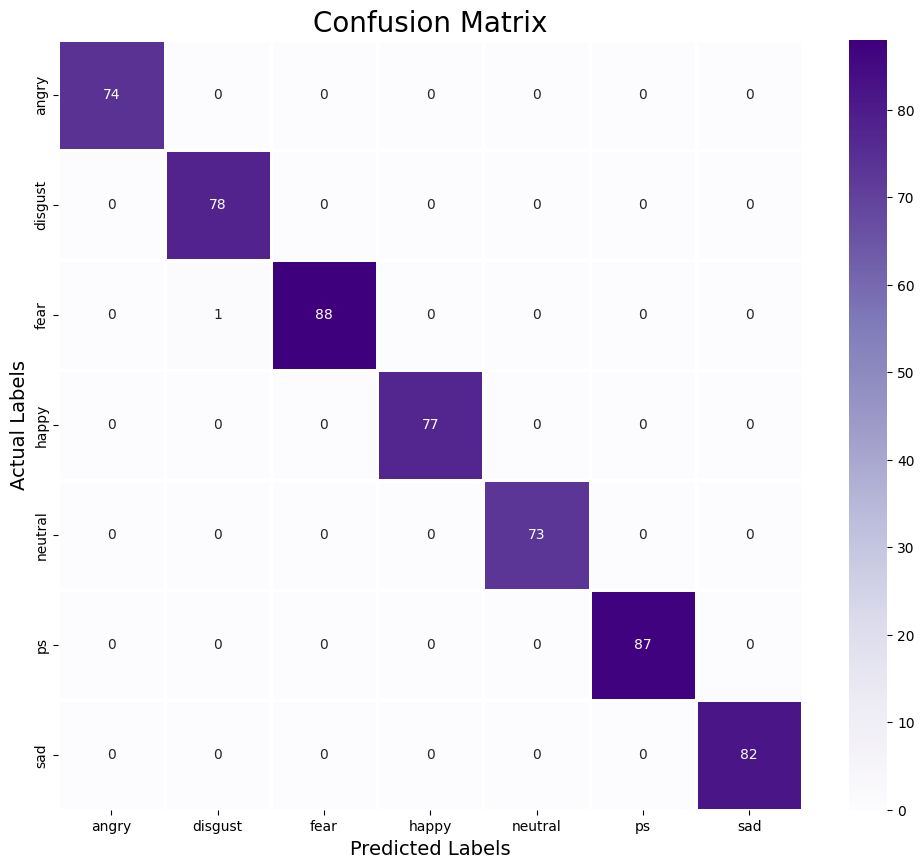

In [183]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test_class, Y_pred_class)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [184]:
from sklearn.metrics import confusion_matrix, classification_report


print(classification_report(Y_test_class, Y_pred_class))

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       0.99      1.00      0.99        78
        fear       1.00      0.99      0.99        89
       happy       1.00      1.00      1.00        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      1.00      1.00        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



## TESTING THE MODEL

In [269]:
import librosa
import numpy as np

def get_zcr(audio, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def get_rmse(audio, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def get_mfcc(audio, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_feature = librosa.feature.mfcc(y=audio, sr=sr)
    return np.ravel(mfcc_feature.T) if flatten else mfcc_feature.T

# Load the new audio file
new_audio_path = r"C:\Users\sarah\Audio test 2- female.wav"
new_audio, sr = librosa.load(new_audio_path, sr=None)

# Extract features from the augmented audio
zcr_feature = get_zcr(new_audio)
rmse_feature = get_rmse(new_audio)
mfcc_feature = get_mfcc(new_audio, sr)


# Define the desired length of the features
#desired_length = 6248  # Adjust based on your requirements

# Reduce the shape of the features to the desired length
zcr_feature = zcr_feature[:284]
rmse_feature = rmse_feature[:284]
mfcc_feature = mfcc_feature[:5680]

# Create a DataFrame
dftest = pd.DataFrame()

# Assign features to DataFrame columns
dftest['ZCR'] = [zcr_feature]
dftest['RMSE'] = [rmse_feature]
dftest['MFCC'] = [mfcc_feature]


# Convert NumPy arrays to tensors
dftest['ZCR'] = dftest['ZCR'].apply(lambda x: torch.tensor(x))
dftest['RMSE'] = dftest['RMSE'].apply(lambda x: torch.tensor(x))
dftest['MFCC'] = dftest['MFCC'].apply(lambda x: torch.tensor(x))

# Expand tensors into individual columns
dftest = pd.concat([dftest.drop(['ZCR', 'RMSE', 'MFCC'], axis=1),
                dftest['ZCR'].apply(pd.Series).add_prefix('ZCR_'),
                dftest['RMSE'].apply(pd.Series).add_prefix('RMSE_'),
                dftest['MFCC'].apply(pd.Series).add_prefix('MFCC_')], axis=1)

# Fill NaN with 0
dftest = dftest.fillna(0)
#print(featured_df.isna().any())
#featured_df.shape

# Load the trained model
with open('NNtrainedmodel.pkl', 'rb') as file:
    NNtrained_model = pickle.load(file)

# Make predictions using the trained model
predictions = NNtrained_model.predict(dftest.values)

# Print the predicted sentiment
print('Predicted sentiment:', predictions)



1/1 [==============================] - 0s 156ms/step
Predicted sentiment: [[0. 0. 0. 0. 1. 0. 0.]]


In [262]:
import speech_recognition as sr
from nltk.sentiment import SentimentIntensityAnalyzer
from IPython.display import Audio

def analyze_audio_sentiment(audio_file):
 
    # Load the audio data
    audio, sample_rate = librosa.load(audio_file)

    # Play the audio
    Audio(data=audio, rate=sample_rate)

        # Initialize the speech recognizer
    recognizer = sr.Recognizer()

    # Load the audio data
    with sr.AudioFile(audio_file) as source:
        audio = recognizer.record(source)

    # Play the audio
    display(Audio(audio_file))
    print('-------------------------------------------')
    # Convert speech to text
    transcript = recognizer.recognize_google(audio)
    print('Speech-to-Text')
    print(transcript)
    print('-------------------------------------------')
    # Perform sentiment analysis on the transcribed text
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(transcript)

    # Print the sentiment scores
    print('Sentiment/Polarity scores')
    print(sentiment_scores)
   # Specify the audio file path
audio_file = r"C:\Users\sarah\Audio test 2- female.wav"

# Call the function to analyze audio sentiment
analyze_audio_sentiment(audio_file)

-------------------------------------------
Speech-to-Text
hi Laura how are you yeah I actually did what you suggested and I think it's working now I'm so glad you you put me through that right thank you very much bye
-------------------------------------------
Sentiment/Polarity scores
{'neg': 0.0, 'neu': 0.766, 'pos': 0.234, 'compound': 0.8208}


In [259]:
# Assuming you have a DataFrame 'df' with columns starting with 'ZCR', 'RMSE', and 'MFCC'

# Define the prefixes
prefixes = ['ZCR', 'RMSE', 'MFCC']

# Initialize a dictionary to store the counts
column_counts = {}

# Count the columns starting with each prefix
for prefix in prefixes:
    prefix_columns = [col for col in dftest.columns if col.startswith(prefix)]
    column_counts[prefix] = len(prefix_columns)

# Print the counts
for prefix, count in column_counts.items():
    print(f"Number of columns starting with '{prefix}': {count}")


Number of columns starting with 'ZCR': 284
Number of columns starting with 'RMSE': 284
Number of columns starting with 'MFCC': 5680
